In [1]:
import requests as r
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Time Series Forecasting Models - Apple Stock Prices

This notebook will go over some techniques of time series forecasting models. [This article](https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/) provides the basis of the following notebook. 
I will go over the seven different forecasting methods, and when to use each. I chose realtime stock prices for Apple as an example as this can be extended further and enhanced for actual use of forecasting prices with higher than average precision. 
Forecasting is a tough problem to solve, because of the volatility of the stock market forecasting when the stocks will crash or rise can be measured only with statistical precision, meaning we can only take the information we have about the data. 

### Let's get the data
Stock prices are every where, we can go to any finance site and get the data for us to use, I chose the API route to get real time stock prices for the past 5 years for Apple. Although 5 years is a long range, this was a reasonable range to use to demonstrate the different types of forecasting models.
For those interested in getting stock prices data, [IEX Trading](https://iextrading.com/developer/docs/#stocks) have a wonderful API with a variety of endpoints, useful for many ML projects. I decided to use this to get Apple's stock price over the last 5 years.

In [2]:
apple = r.get("https://api.iextrading.com/1.0/stock/aapl/chart/5y").json()
apple_df = pd.DataFrame(apple, columns=['change','changeOverTime','changePercent','close','date',
                                                  'high','label','low','open','unadjustedVolume','volume','vwap'])

### The Data
We are only going to use the **close** column to get the closing price of each day, the rest of the columns could be used in the future for Deep Learning prediction using Recurrent Nueral Networks. There are 1260 data points over the last 5 years (1800 days), so there are a few missing values which we will impute further down.

In [3]:
apple_df.head()

,change,changeOverTime,changePercent,close,date,high,label,low,open,unadjustedVolume,volume,vwap
0,0.120753,0.000000,0.178,68.1184,2013-11-19,68.6206,"Nov 19, 13",67.9113,68.0502,7462101,52234707,68.2233
1,-0.596551,-0.008757,-0.876,67.5219,2013-11-20,68.2325,"Nov 20, 13",67.4340,68.0765,6935114,48545798,67.8431
2,0.804492,0.003054,1.191,68.3264,2013-11-21,68.3361,"Nov 21, 13",67.3475,67.8628,9358123,65506861,67.9121
3,-0.175164,0.000482,-0.256,68.1512,2013-11-22,68.4606,"Nov 22, 13",67.9847,68.1145,7990176,55931232,76.3685
4,0.516575,0.008065,0.758,68.6678,2013-11-25,68.9470,"Nov 25, 13",68.3085,68.3112,8192629,57348403,68.7518


In [4]:
# Apply Forcasting to this data
apple_df.count()

change              1259
changeOverTime      1259
changePercent       1259
close               1259
date                1259
high                1259
label               1259
low                 1259
open                1259
unadjustedVolume    1259
volume              1259
vwap                1259
dtype: int64

### Split the data
I've split the data with a 75% split between train and test, the test data is going to be used to forecast future prices. 

In [5]:
train = apple_df[0:945]
test = apple_df[945:]

In [6]:
train.head()

,change,changeOverTime,changePercent,close,date,high,label,low,open,unadjustedVolume,volume,vwap
0,0.120753,0.000000,0.178,68.1184,2013-11-19,68.6206,"Nov 19, 13",67.9113,68.0502,7462101,52234707,68.2233
1,-0.596551,-0.008757,-0.876,67.5219,2013-11-20,68.2325,"Nov 20, 13",67.4340,68.0765,6935114,48545798,67.8431
2,0.804492,0.003054,1.191,68.3264,2013-11-21,68.3361,"Nov 21, 13",67.3475,67.8628,9358123,65506861,67.9121
3,-0.175164,0.000482,-0.256,68.1512,2013-11-22,68.4606,"Nov 22, 13",67.9847,68.1145,7990176,55931232,76.3685
4,0.516575,0.008065,0.758,68.6678,2013-11-25,68.9470,"Nov 25, 13",68.3085,68.3112,8192629,57348403,68.7518


### Preprocess Data
First we will convert the date column to an actual datetime dtype using `pd.to_datetime`. Since time is the indicator of a stock price we will set the date as the index.

#### Resampling
Since we have missing data in the 5 years of stock prices, we use a [resampling method](https://machinelearningmastery.com/resample-interpolate-time-series-data-python/) to impute values (which replaces the missing values with the mean) for the missing day using a linear approach (because we can see the stock generally increase linearly), we could finetune the method to use `spline` which is a polynomial interpolation, but for the purposes of this example it shouldn't affect the forecasting methods at all.


In [7]:
train.date = pd.to_datetime(train.date, format="%Y-%m-%d")
train.index = train.date
test.date = pd.to_datetime(test.date, format="%Y-%m-%d")
test.index = test.date

train = train.resample('D').mean()
train = train.interpolate(method='linear')

test = test.resample('D').mean()
test = test.interpolate(method='linear')

/Users/joshishushruth/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### Plot the initial data
Below is the plot of Apple's stock prices over the last 5 years, we can see an increasing trend in the data, and without using any forecasting methods we can assume with a high degree of confidence the general trend over the next few years will also be an increasing trend, however we can assume such for the next few weeks or even months, because from the data we can see there were massive dips in the stock prices from time to time, this is where the forecasting methods will come in handy. If we can use these methods to get a general trand over a short period of time in the future we can make decisions on whether to buy or sell.
The graph splits the training set and the test set as two different plots, because we are only trying to predict the trend for the test data using training data.

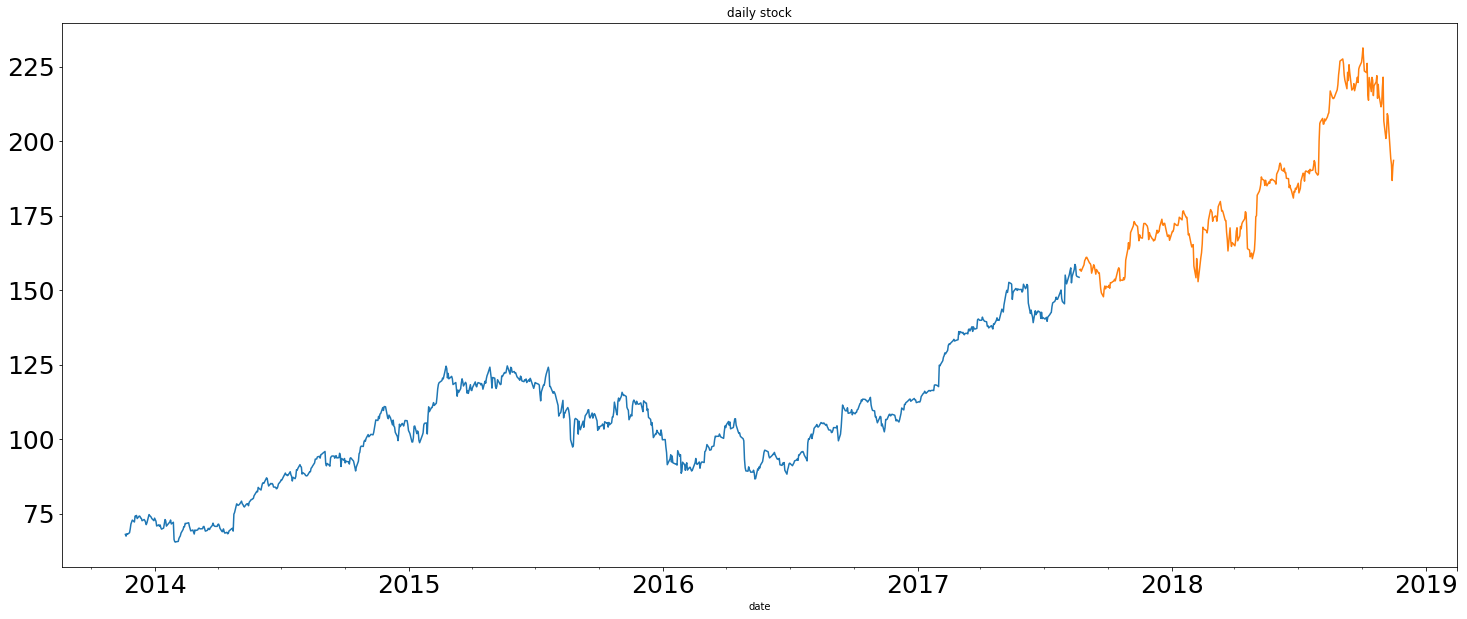

In [8]:
train.close.plot(figsize=(25,10), title='daily stock', fontsize=25)
test.close.plot()
plt.savefig('./figures/initial_plot.png')

### Method 1 - The Naive Approach
The very first and most basic approach we can use is the naive approach which just gathers up all of the training data and takes the previous value of the each data set and applies it to the next data point. The Green line shows the general trend of the prediction. It is clear that this is a bad predictor for the stock prices as it doesn't say much about what the price will be. 

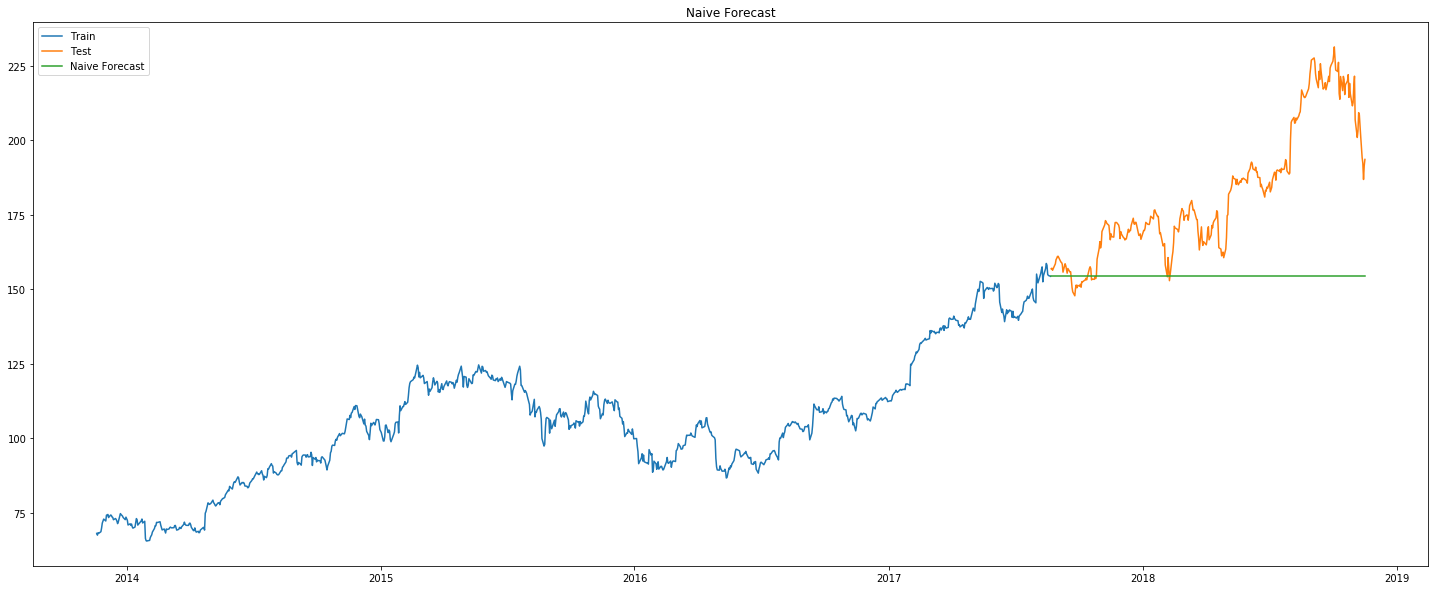

In [9]:
# Using naive approach
dd = np.asarray(train.close)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd) - 1]
plt.figure(figsize=(25,10))
plt.plot(train.index, train['close'], label='Train')
plt.plot(test.index, test['close'], label='Test')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.savefig('./figures/naive_approach.png')

### Method 2 - Average
The next method is a more reasonable one ... in most cases. It takes the average of all the data and applies it to the test set. However you can see that is did much worse than the naive method, and this is due to the volatility of the stock market, taking the average of the last 5 years is not the way to go.

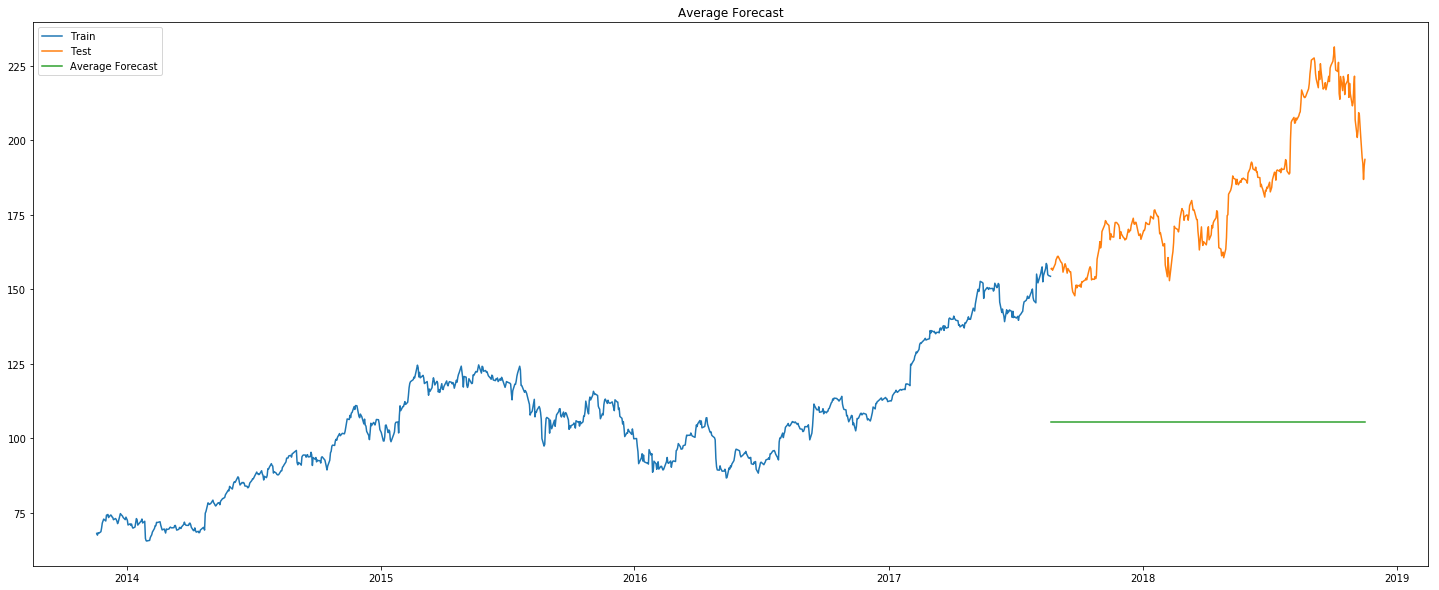

In [10]:
y_hat_avg = test.copy()
y_hat_avg['avg_forcast'] = train.close.mean()
plt.figure(figsize=(25,10))
plt.plot(train['close'], label='Train')
plt.plot(test['close'], label='Test')
plt.plot(y_hat_avg['avg_forcast'], label='Average Forecast')
plt.legend(loc='best')
plt.title('Average Forecast')
plt.savefig('./figures/simple_average.png')

### Method 3 - The Rolling Average
The next method is to use the rolling average, this is a slightly better predictor, because it acts like a window slider, taking the average of a window at a time, and accumalating the average. I used a window of around 90 data points to accumalate the mean. It is clear that when forecasting stock prices, using Averages are not the way to go. However the rolling average forecasting method can be used for smaller data. 

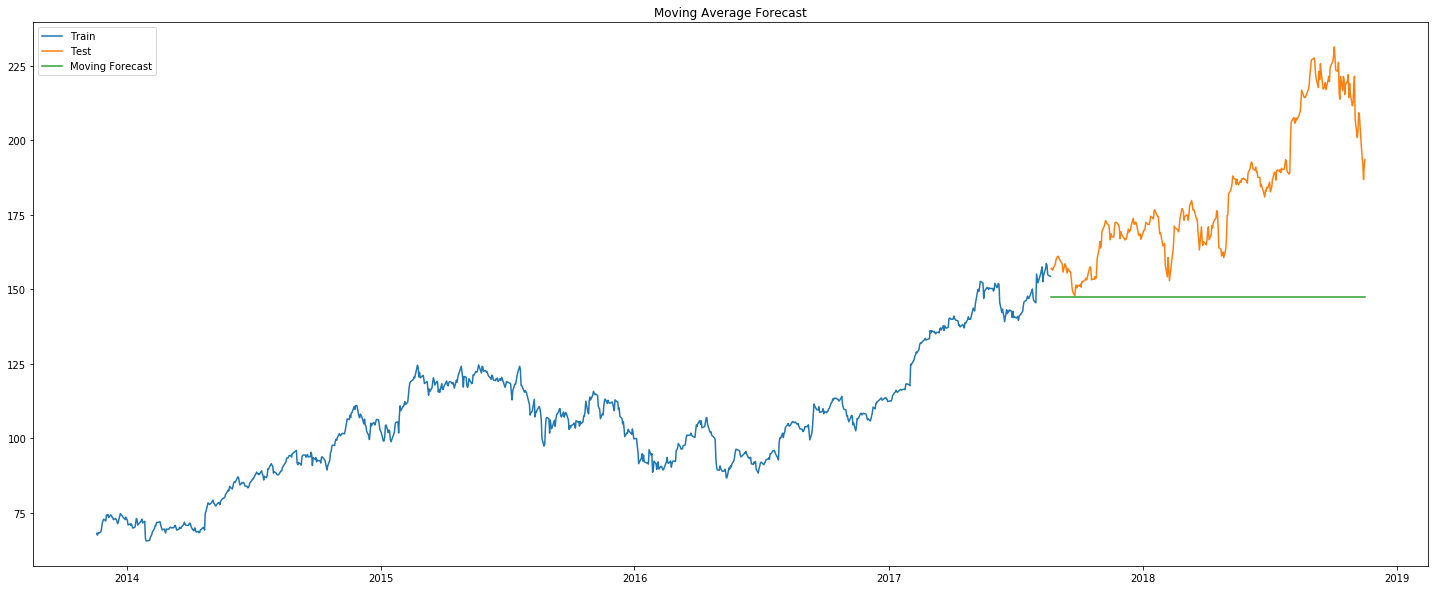

In [11]:
y_hat_avg_moving = test.copy()
y_hat_avg_moving['moving_avg_forcast'] = train.close.rolling(90).mean().iloc[-1]
plt.figure(figsize=(25,10))
plt.plot(train['close'], label='Train')
plt.plot(test['close'], label='Test')
plt.plot(y_hat_avg_moving['moving_avg_forcast'], label='Moving Forecast')
plt.legend(loc='best')
plt.title('Moving Average Forecast')
plt.savefig('./figures/rolling_average.png')

### Method 4 - Simple Exponential Smoothing
It is fair to conclude for the purposes of stock prices taking simple or rolling averages is too extreme a predcitor, due to the volatile nature of stocks. Simple Exponential Smoothing is a enhacanes rolling averages by assigning weights to each data point. The older the data, the lower the weight (in fact is get's exponentially lower as you go into the past). Giving more weights to recent data will give an accurate representation of the future because it will base it's prediction of the most recent data. From the graph we can see that the predictor is very similar to the Simple Average plot, the reason for this maybe because of the extreme change in stock prices between the training set and the test set. It seemed this method was not enough to predict the massive spike around 2017, this is because the training set has not observed spikes that large yet. 

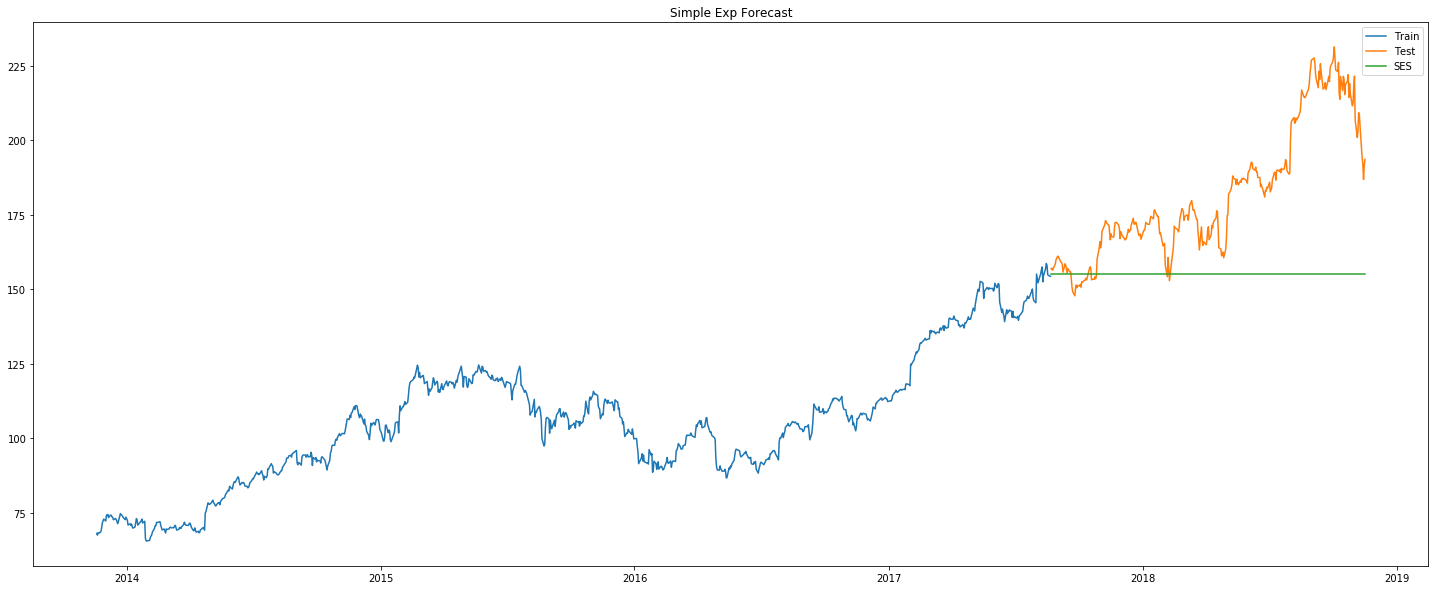

In [12]:
# Simple Exponential Smoothing - Combines moving averages with weights, giving lower and lower weights to data points furhter into the past
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_ses = test.copy()
fit = SimpleExpSmoothing(np.asarray(train.close)).fit(smoothing_level=0.2, optimized=False)
y_hat_ses['SES'] = fit.forecast(len(test))
plt.figure(figsize=(25,10))
plt.plot(train['close'], label='Train')
plt.plot(test['close'], label='Test')
plt.plot(y_hat_ses['SES'], label='SES')
plt.legend(loc='best')
plt.title('Simple Exp Forecast')
plt.savefig('./figures/simple_exp_smoothing.png')

### Enter Holts Trends and Seasonality
All the methods up till now was just not able to handle the high variations of stock price changes. Charles Holts (Professor of Management at a School of Business) identified a mathematical correlation between the averages we calculated above called levels and trends. Trends describe a linear relation in the data. So the forecast is no longer just a constant line, but a linear trend depicting the direction of the forecast over a period of time. The forecast is found by adding the **Simple Exponential Smoothing** above to the rolling averages and the Trend, to get an overall linear forecast to the data.

### Depicting Holts Trends
The graph below shows Holts trends. The Observed shows the graph as we see it in the plots, the Trends compiles the observed data and identifies a linear pattern in the data (as a general direction). This is what we will use to plot the forecast pattern

<Figure size 1800x720 with 0 Axes>

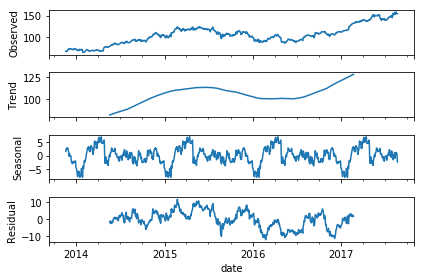

In [13]:
import statsmodels.api as sm
plt.figure(figsize=(25,10))
sm.tsa.seasonal_decompose(train['close'], freq=365).plot()
result = sm.tsa.stattools.adfuller(train['close'])
plt.show('./figures/holts_trends.png')

### Method 5 - Holts Trend
We can see a much cleaner representation of the stock price using Holts' trend method. Although there is a dip at the very end of the stock price, Holts trend forecasts a general increase in the trend over time. 

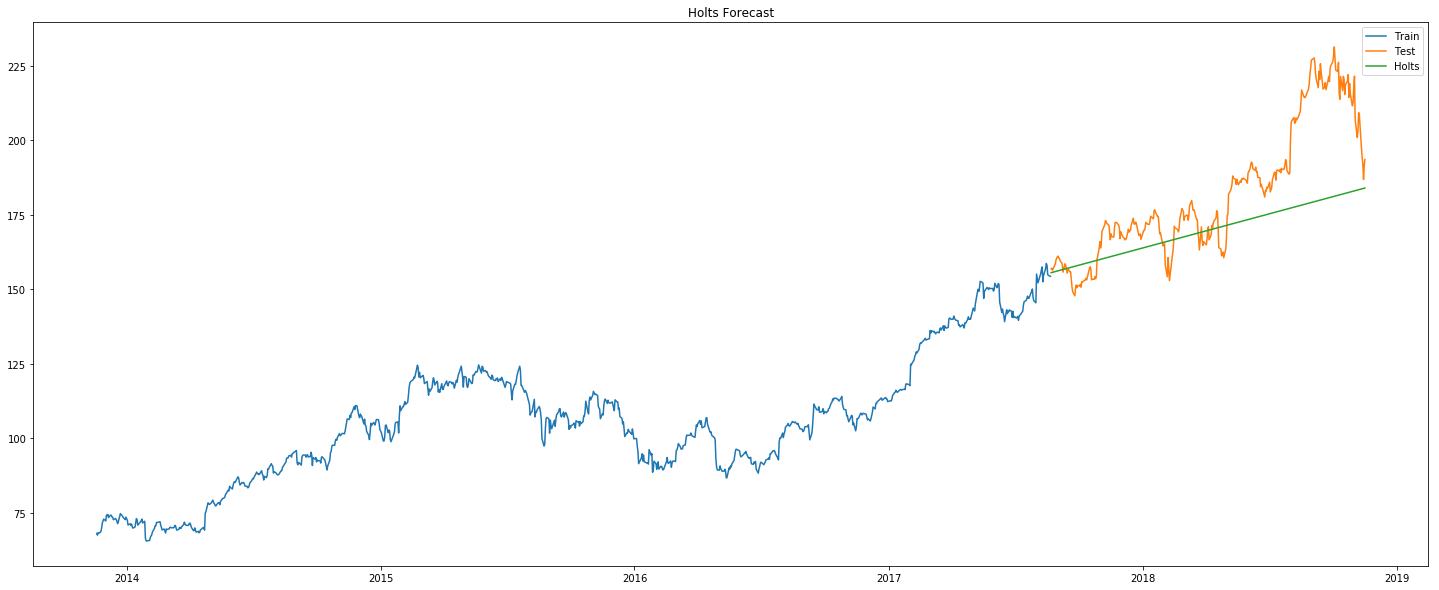

In [14]:
y_hat_holt = test.copy()
fit1 = Holt(np.asarray(train.close)).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_holt['Holt'] = fit1.forecast(len(test))
plt.figure(figsize=(25,10))
plt.plot(train['close'], label='Train')
plt.plot(test['close'], label='Test')
plt.plot(y_hat_holt['Holt'], label='Holts')
plt.legend(loc='best')
plt.title('Holts Forecast')
plt.savefig('./figures/holts_trend.png')

### Method 6 - Holt's Winter Method
From the Holts trends graph, there was a seasonal depiction of the data. Holt came up with a mathematical equation to take into account any seasonal trends in the data, however with stock prices seasons can be seen as periods of time where we see dips and rises. If we consider every year as a new season, meaning the method will generate patterns per year, we can start to see interesting predictions in the future. According to the seasonal trends it predicted a major dip in price around 2018, although this was not the case, the seasonal method demonstrates a more realistic nature of the stock price. Playing around with the parameters may give better predictions.

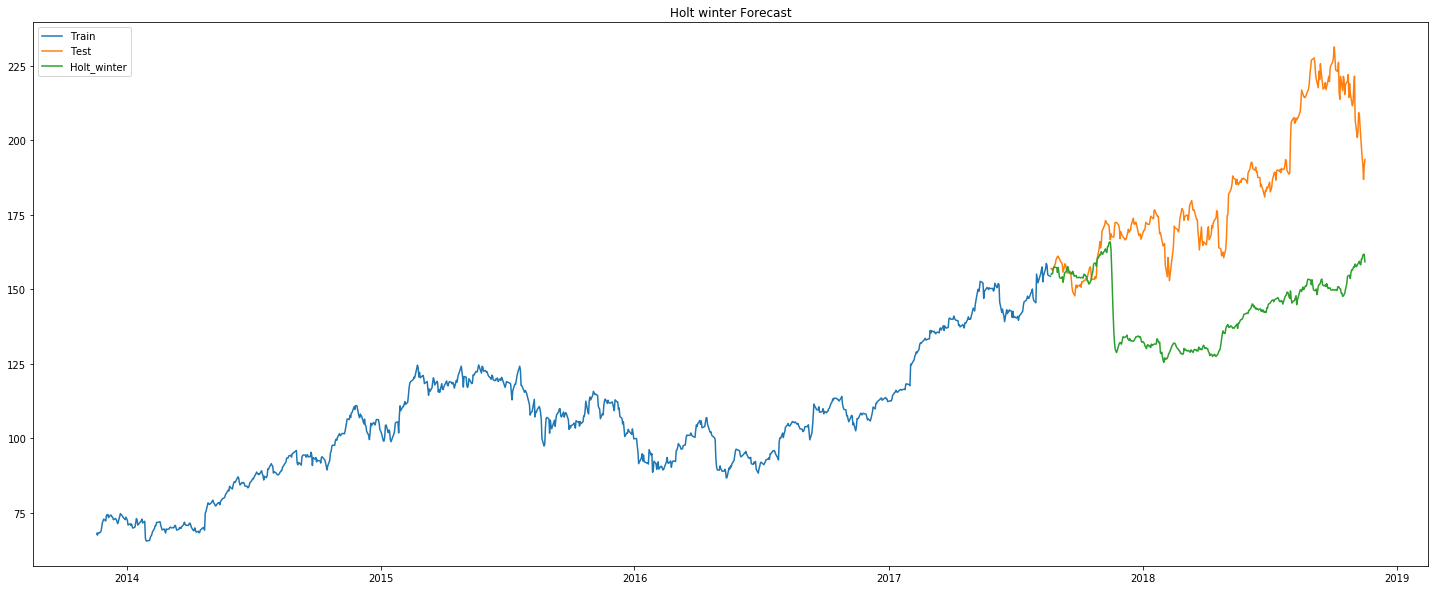

In [15]:
y_hat_holt_winter = test.copy()
fit2 = ExponentialSmoothing(np.asarray(train.close), seasonal_periods=365, trend='add', seasonal='add').fit()
y_hat_holt_winter['Holt_winter'] = fit2.forecast(len(test))
plt.figure(figsize=(25,10))
plt.plot(train['close'], label='Train')
plt.plot(test['close'], label='Test')
plt.plot(y_hat_holt_winter['Holt_winter'], label='Holt_winter')
plt.legend(loc='best')
plt.title('Holt winter Forecast')
plt.savefig('./figures/holts_winter_trend.png')

### Method 7 - S-ARIMA 
ARIMA stands for **Autogregressive Integrated Moving Average**, the purpose of this is it tries to find correlations between its own data points (ie it performs regression on itself), instead of finding the trend and the seasonal patterns. ARIMA uses historical data to forecast the future and to understand the historical patterns.
There are two requirements to using an ARIMA model:
* The data is **stationary** meaning the data should not be a function of time, it should instead me constant. However in our case the data is **non-stationary** as the stock prices generally increase with time. Stationary also refers to the degree of variance in the data, the variance should be approximately constant, and still our data it not stationary because of the high degrees of variance.

* There is no seasonality - if the point of ARIMA is to find patterns in historical data, it cannot have major fluctuations in the data, if it does the data is usually decomposed so the data can be more predictable.

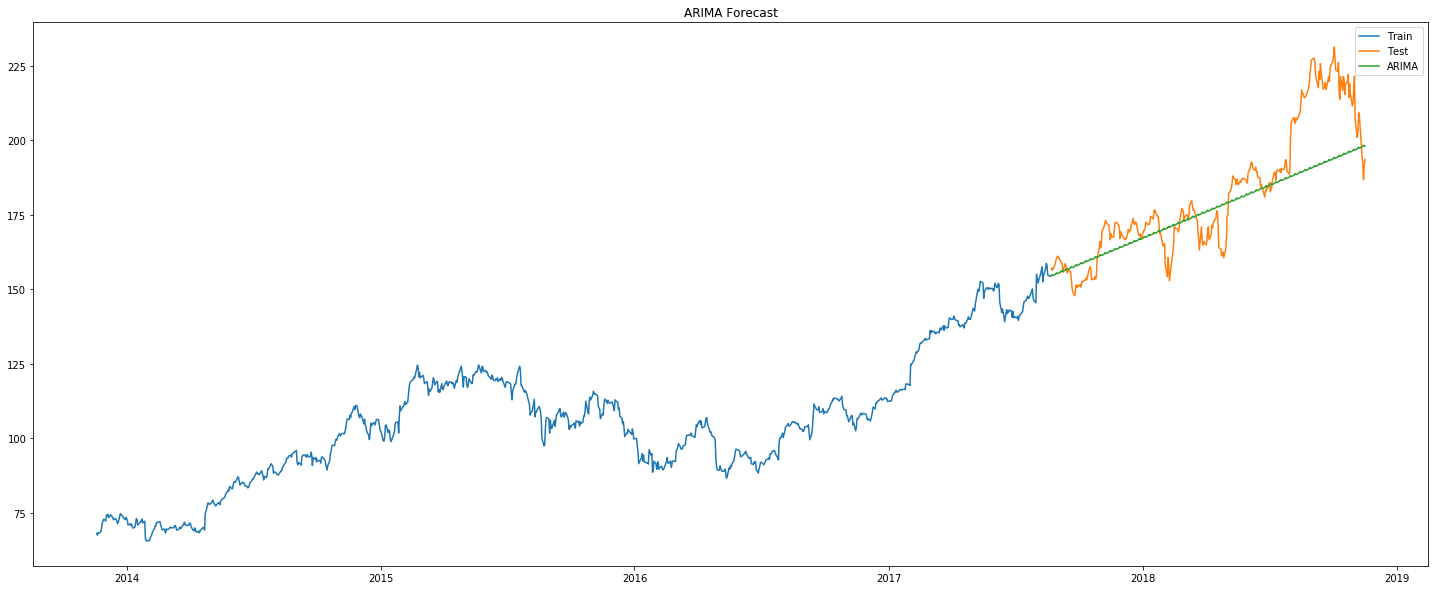

In [16]:
y_hat_arima = test.copy()
fit3 = sm.tsa.statespace.SARIMAX(train.close, order=(2,1,4), seasonal_order=(0,1,1,7)).fit()
y_hat_arima['ARIMA'] = fit3.forecast(len(test))
plt.figure(figsize=(25,10))
plt.plot(train['close'], label='Train')
plt.plot(test['close'], label='Test')
plt.plot(y_hat_arima['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.title('ARIMA Forecast')
plt.savefig('./figures/s_arima.png')

### Results

If we get the mean squared error from the methods mentioned above, we can see the S-ARIMA and HOLTS methods work well with the apple stock data. Understanding these forecasting methods is complicated and usually requires your data is cleaned and processed well. Forecasting is useful to get a general prediction of the trend for a time series plot, it is usually better than taking a guess, but if we were to implement Deep Learning using Reinforcement models this could be further improved.

In [17]:
# Get RMS vals

rms_naive = sqrt(mean_squared_error(test.close, y_hat.naive))
print('NAIVE',rms_naive)

rms_avg = sqrt(mean_squared_error(test.close, y_hat_avg.avg_forcast))
print('AVERAGE',rms_avg)

rms_avg_rolling = sqrt(mean_squared_error(test.close, y_hat_avg_moving.moving_avg_forcast))
print('ROLLING AVERAGE',rms_avg_rolling)

rms_avg_ses = sqrt(mean_squared_error(test.close, y_hat_ses.SES))
print('SIMPLE EXP SMOOTHING',rms_avg_ses)

rms_avg_holts = sqrt(mean_squared_error(test.close, y_hat_holt.Holt))
print('HOLTS',rms_avg_holts)

rms_avg_holts_winter = sqrt(mean_squared_error(test.close, y_hat_holt_winter.Holt_winter))
print('HOLTS WINTER TRENDS',rms_avg_holts_winter)

y_hat_arima = y_hat_arima.fillna(y_hat_arima.ARIMA.mean())
rms_avg_sarimax = sqrt(mean_squared_error(test.close, y_hat_arima.ARIMA))
print('ARIMA',rms_avg_sarimax)

NAIVE 35.113145638275675
AVERAGE 79.45610947224213
ROLLING AVERAGE 40.631483723550595
SIMPLE EXP SMOOTHING 34.53220822122559
HOLTS 19.263460133674407
HOLTS WINTER TRENDS 44.118015067104636
ARIMA 13.237931735649548
